In [2]:
import pandas as pd
import scipy as sc
import glob
import os
import numpy as np
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

In [3]:
def prepare_plot():
    """
    Set up general plot aesthetics to be used for including figures in a manuscript or talk.
    These defaults are possibly too large for interactive use.
    This function should be called before `paper_plot`.
    """
    sns.set()
    # Increase font size and linewidth
    sns.set_context("talk")
    sns.set_style("whitegrid")
    # Use LaTeX, setup to use Helvetica. This can be safely commented to make
    # the installation footprint of running this code smaller -- for example,
    # in Docker.
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [
        r'\usepackage{amsmath}',
        r'\usepackage{helvet}',
        r'\usepackage[EULERGREEK]{sansmath}',
        r'\sansmath',
        r'\renewcommand{\familydefault}{\sfdefault}',
        r'\usepackage[T1]{fontenc}',
        r'\usepackage{graphicx}'
    ]

def paper_plot(fig, adjustment=0, scientific=False, save=False, filename=None,
               raster=False, label_pad=True):
    """
    Take a prepared figure and make additional adjustments for inclusion in manuscript:
    mostly tick thickness, length, and label padding, and include only the left and the bottom
    axis spines. It would be nice to force the axes to end on a major tick, but I haven't
    figured out how to do that yet.
    """
    for ax in fig.axes:
        # Increase padding
        ax.tick_params(which='major', direction='out', length=10, pad=10)
        ax.tick_params(which='minor', direction='out', length=5)
        # If plotting with pi, increase the x tick size specifically
        # ax.tick_params(axis='x', labelsize=40, pad=-10)
        # Increase tick thickness
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if label_pad:
            # Increase padding
            ax.xaxis.labelpad = 15
            ax.yaxis.labelpad = 15
        # Make the background color white
        facecolor = 'white'
        if facecolor is False:
            facecolor = fig.get_facecolor()
        alpha = 1
        color_with_alpha = colorConverter.to_rgba(facecolor, alpha)
        fig.patch.set_facecolor(color_with_alpha)
        # Stick the scientific notation into the axis label, instead of the
        # default position which in the corner, which really makes no sense.
        if ax.xaxis.get_scale() == 'linear':
            if scientific:
                pretty_label(ax)
            ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
            ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        elif ax.xaxis.get_scale() == 'log':
            pass
        # For scatter plots, where points get cut off
        if adjustment != 0:
            x0, x1, y0, y1 = ax.axis()
            ax.xaxis((x0 - adjustment,
                      x1 + adjustment,
                      y0,
                      y1
                     ))
        # Make axes thicker
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)
    if save:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(filename + '.svg', dpi=300, bbox_inches='tight')


In [4]:
prepare_plot()

In [5]:
def thermodynamic_bootstrap(
    x, x_sem, y, y_sem, cycles=1000, with_replacement=True, with_uncertainty=True
):
    summary_statistics = np.empty((cycles))
    R = 1.987204118e-3 # kcal/mol-K
    temperature = 300  # K
    beta = 1.0 / (R * temperature)

    for cycle in range(cycles):
        new_x = np.empty_like(x)
        new_y = np.empty_like(y)

        if with_uncertainty and x_sem is not None:
            new_x = np.random.normal(x, x_sem)
        elif with_uncertainty and x_sem is None:
            new_x = x
        if with_uncertainty and y_sem is not None:
            new_y = np.random.normal(y, y_sem)
        elif with_uncertainty and y_sem is None:
            new_y = y
        summary_statistics[cycle] = -R * temperature * np.log(np.exp(-beta * new_x) + np.exp(-beta * new_y))
      
    results = {
        "mean": np.mean(summary_statistics),
        "sem": np.std(summary_statistics)
    }
    return results

In [6]:
# https://stackoverflow.com/questions/6800193/what-is-the-most-efficient-way-of-finding-all-the-factors-of-a-number-in-python
# THis is good.
from functools import reduce


def fctors(n):
    return sorted(
        list(
            set(
                reduce(
                    list.__add__,
                    ([i, n // i] for i in range(1, int(n ** 0.5) + 1) if n % i == 0),
                )
            )
        )
    )


In [7]:
def get_nearest_max(n):
    """
    Return the number with the largest number of factors between n-100 and n.
    """
    num_factors = []
    max_factors = 0
    if n % 2 == 0:
        beg = n - 100
        end = n
    else:
        beg = n - 101
        end = n - 1
    if beg < 0:
        beg = 0
    for i in range(beg, end + 2, 2):
        num_factors = len(fctors(i))
        if num_factors >= max_factors:
            max_factors = num_factors
            most_factors = i
    return most_factors


In [8]:
def get_block_sem(data_array):
    """
    Compute the standard error of the mean (SEM) for a data_array using the blocking method."
    """
    # Get the integer factors for the number of data points. These
    # are equivalent to the block sizes we will check.
    block_sizes = fctors(len(data_array))

    # An array to store means for each block ... make it bigger than we need.
    block_means = np.zeros([block_sizes[-1]], np.float64)

    # Store the SEM for each block size, except the last two size for which
    # there will only be two or one blocks total and thus very noisy.
    sems = np.zeros([len(block_sizes) - 2], np.float64)
    sems_error = np.zeros([len(block_sizes) - 2], np.float64)

    
    # Check each block size except the last two.
    for size_idx in range(len(block_sizes) - 2):
        # Check each block, the number of which is conveniently found as
        # the other number of the factor pair in block_sizes
        num_blocks = block_sizes[-size_idx - 1]
        for blk_idx in range(num_blocks):
            # Find the index for beg and end of data points for each block
            data_beg_idx = blk_idx * block_sizes[size_idx]
            data_end_idx = (blk_idx + 1) * block_sizes[size_idx]
            # Compute the mean of this block and store in array
            block_means[blk_idx] = np.mean(data_array[data_beg_idx:data_end_idx])
        # Compute the standard deviation across all blocks, devide by num_blocks-1 for SEM
        sems[size_idx] = np.std(block_means[0:num_blocks], ddof=0) / np.sqrt(
            num_blocks - 1
        )
        # Hmm or should ddof=1? I think 0, see Flyvbjerg -----^
        sems_error[size_idx] = sems[size_idx] / np.sqrt(2 * (num_blocks - 1))

        # print(f"Block size index: {size_idx}, Block size: {block_sizes[size_idx]}, Number of sub-blocks: {num_blocks}, Mean: {np.mean(block_means[0:num_blocks])}, SEM: {sems[size_idx]}")
    # Return the max SEM found ... this is a conservative approach.
    
    #plt.semilogx(block_sizes[:-2], sems, '-o')
    # ax.set_xscale("log", nonposx='clip')
    # ax.set_yscale("log", nonposy='clip')

    # plt.ylabel("SEM (kca/mol)")
    # plt.xlabel("Block size")
    return np.max(sems)


In [9]:
files = glob.glob("systems/b-mch-p/smirnoff/a000/prod.*.mden")
epot_s = []
for file in files:
    with open(file, "r") as f:
        for line in f.readlines()[10:]:
            words = line.rstrip().split()
            if words[0] == "L6":
                epot_s.append(float(words[2]))


In [10]:
files = glob.glob("/home/dslochower//niel/projects/cds/wat6/bgbg-tip3p/b-mch-p/a00/mden.*")
epot_b = []
for file in files:
    with open(file, "r") as f:
        for line in f.readlines()[10:]:
            words = line.rstrip().split()
            if words[0] == "L6":
                epot_b.append(float(words[2]))


In [11]:
df = pd.DataFrame({
    "SMIRNOFF99Frosst": epot_s,
    "BGBG-TIP3P": epot_b
})
df.to_csv("b-mch-p-a000-total-potential.csv")

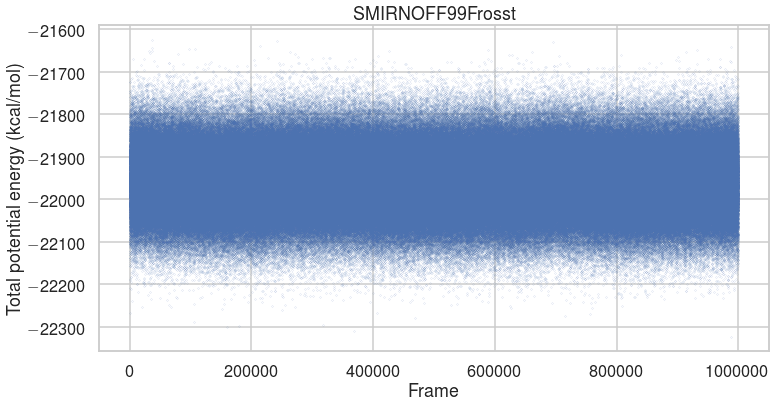

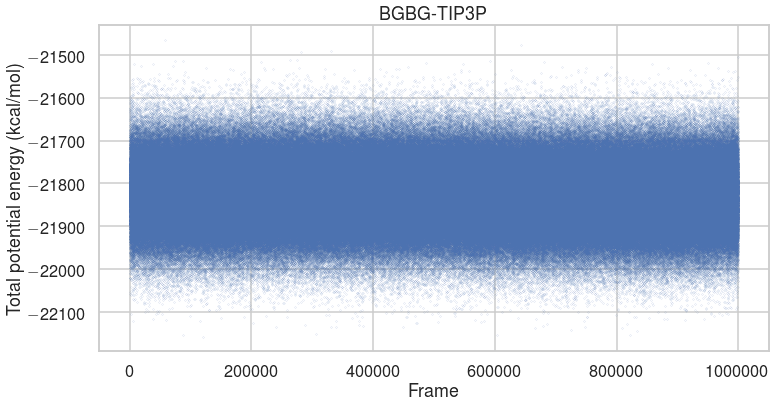

In [15]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(range(len(epot_s)), epot_s, s=0.01)
plt.xlabel("Frame")
plt.ylabel("Total potential energy (kcal/mol)")
plt.title("SMIRNOFF99Frosst")
plt.savefig("total-potential-smirnoff99frosst.png")

fig = plt.figure(figsize=(12, 6))
plt.scatter(range(len(epot_b)), epot_b, s=0.01)
plt.xlabel("Frame")
plt.ylabel("Total potential energy (kcal/mol)")
plt.title("BGBG-TIP3P")
plt.savefig("total-potential-bgbg-tip3p.png")

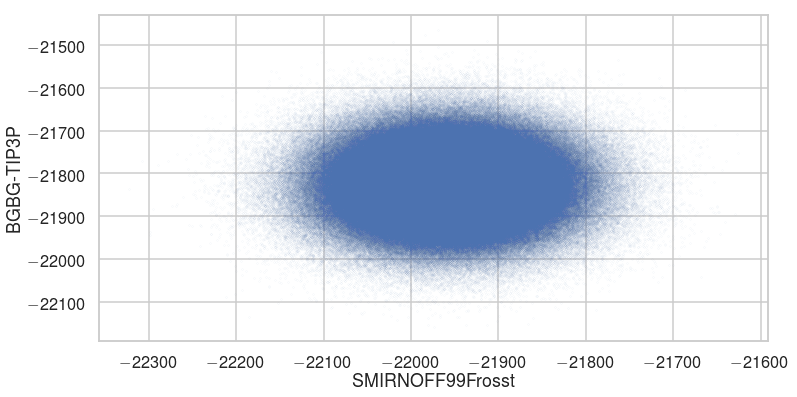

In [13]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(epot_s, epot_b, s=0.001)
plt.xlabel("SMIRNOFF99Frosst")
plt.ylabel("BGBG-TIP3P")


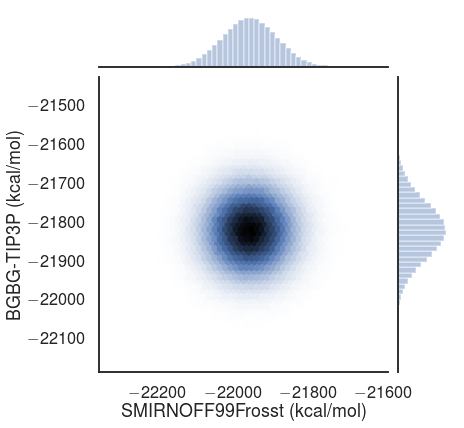

In [22]:
with sns.axes_style("white"):
    h = sns.jointplot(epot_s, epot_b, kind="hex")
    h.set_axis_labels("SMIRNOFF99Frosst (kcal/mol)", "BGBG-TIP3P (kcal/mol)")
    h.savefig('total-potential-bgbg-tip3p-vs-smirnoff99frosst.png')

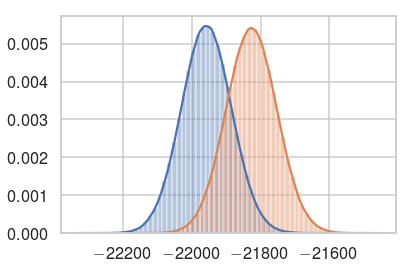

In [25]:
sns.distplot(epot_s)
sns.distplot(epot_b)

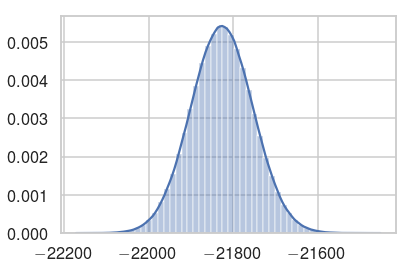

In [27]:
fctors(len(vdw))

[1, 2, 4, 5, 100, 1000, 200, 8, 10, 40, 50, 500, 20, 25, 250, 125]

In [92]:
import numpy as np
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

method = 'cholesky'
num_samples = 1000000
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])
x = norm.rvs(size=(3, num_samples))
if method == 'cholesky':
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    # Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

# Convert the data to correlated random variables. 
y = np.dot(c, x)


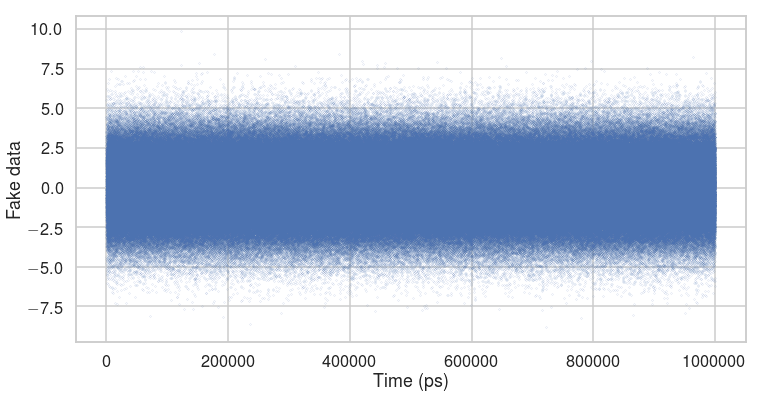

In [101]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(range(len(y[0])), y[0], s=0.01)
plt.xlabel("Time (ps)")
plt.ylabel("Fake data")

Block size index: 0, Block size: 1, Number of sub-blocks: 1000000, Mean: -0.002755974704292824, SEM: 0.0018440857592511544
Block size index: 1, Block size: 2, Number of sub-blocks: 500000, Mean: -0.002755974704292823, SEM: 0.0018441226416783675
Block size index: 2, Block size: 4, Number of sub-blocks: 250000, Mean: -0.0027559747042928255, SEM: 0.001841369544856806
Block size index: 3, Block size: 5, Number of sub-blocks: 200000, Mean: -0.0027559747042928246, SEM: 0.0018402904324212514
Block size index: 4, Block size: 8, Number of sub-blocks: 125000, Mean: -0.0027559747042928255, SEM: 0.0018413543842880067
Block size index: 5, Block size: 10, Number of sub-blocks: 100000, Mean: -0.002755974704292825, SEM: 0.0018368833737003956
Block size index: 6, Block size: 16, Number of sub-blocks: 62500, Mean: -0.0027559747042928255, SEM: 0.0018371650329929905
Block size index: 7, Block size: 20, Number of sub-blocks: 50000, Mean: -0.0027559747042928263, SEM: 0.00183019062246949
Block size index: 8,

0.0024752411803251129

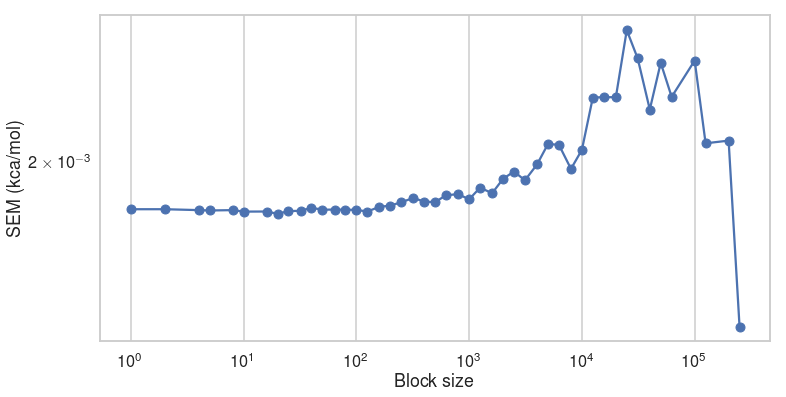

In [102]:
get_block_sem(y[0])

In [237]:
def get_energies_for_enthalpy(mden):
    """
    Modeled after Niel's version.
    """

    vdw = []
    ele = []
    ebnd = []

    with open(mden, "r") as f:
        for line in f.readlines()[10:]:
            words = line.rstrip().split()
            if words[0] == "L6":
                vdw.append(float(words[3]))
                ele.append(float(words[4]))
            elif words[0] == "L7":
                bnd = words[2]
                ang = words[3]
                dih = words[4]
            elif words[0] == "L8":
                v14 = words[1]
                e14 = words[2]
                ebnd.append(
                    float(bnd) + float(ang) + float(dih) + float(v14) + float(e14)
                )
    return ebnd, vdw, ele


In [238]:
tmp, tmp2, tmp3 = get_energies_for_enthalpy("systems/a-bam-p/smirnoff/a000/prod.000.mden")

In [244]:
total = [i + j + k for i, j, k in zip(tmp, tmp2, tmp3)]

In [246]:
np.std(total)

69.555724828825618

In [135]:
systems = """./a-bam-p
./a-bam-s
./a-but-p
./a-but-s
./a-cbu-p
./a-chp-p
./a-cbu-s
./a-chp-s
./a-cpe-p
./a-coc-p
./a-coc-s
./a-cpe-s
./a-hep-p
./a-ham-s
./a-ham-p
./a-hep-s
./a-hp6-p
./a-hex-p
./a-hex-s
./a-hp6-s
./a-hx2-p
./a-hpa-s
./a-hpa-p
./a-hx2-s
./a-mba-p
./a-hx3-s
./a-hx3-p
./a-mba-s
./a-mhp-p
./a-mha-p
./a-mha-s
./a-mhp-s
./a-nmh-p
./a-nmb-p
./a-nmb-s
./a-nmh-s
./a-oct-p
./a-oam-p
./a-oam-s
./a-oct-s
./a-pnt-p
./a-pam-p
./a-pam-s
./a-pnt-s
./b-ben-s
./a-xxxx-s
./b-ben-p
./b-cbu-p
./b-cbu-s
./b-chp-s
./b-chp-p
./b-coc-s
./b-coc-p
./b-cpe-s
./b-cpe-p
./b-ham-s
./b-ham-p
./b-hep-s
./b-hep-p
./b-hex-p
./b-hex-s
./b-m4c-s
./b-m4c-p
./b-m4t-p
./b-m4t-s
./b-mch-s
./b-mha-s
./b-mha-p
./b-mch-p
./b-mo3-s
./b-mo4-p
./b-mo4-s
./b-mo3-p
./b-mp3-s
./b-mp4-s
./b-mp4-p
./b-mp3-p
./b-oam-s
./b-pb3-s
./b-pb3-p
./b-oam-p
./b-pb4-s
./b-pha-s
./b-pb4-p
./b-pha-p
./b-pnt-s
./b-pnt-p"""
systems = systems.split("\n")
systems = [i[2:] for i in systems]
systems = [i for i in systems if "xxxx" not in i]

In [247]:
# end_point_energies = {}
# for system in tqdm(systems):
#     end_point_energies[system] = {}
#     for window in ["a000", "p045"]:
#         end_point_energies[system][window] = {}
#         mden_files = glob.glob(os.path.join("systems", system, "smirnoff", window) + "/prod*.mden")
#         e_bond, e_vdw, e_ele = [], [], [] 
#         for file in mden_files:
#             bnd, vdw, ele = get_energies_for_enthalpy(file)
#             [e_bond.append(i) for i in bnd]
#             [e_vdw.append(i) for i in vdw]
#             [e_ele.append(i) for i in ele]
#         total = [i + j + k for i, j, k in zip(e_bond, e_vdw, e_ele)]
#         end_point_energies[system][window]["total"] = [np.mean(total),
#                                                        get_block_sem(total)]
#         end_point_energies[system][window]["bond"] = [np.mean(e_bond), get_block_sem(e_bond)]
#         end_point_energies[system][window]["ele"] = [np.mean(e_ele), get_block_sem(e_ele)]
#         end_point_energies[system][window]["vdw"] = [np.mean(e_vdw), get_block_sem(e_vdw)]
#         # print(system, window, np.mean(e_bond), np.std(e_bond))

  1%|          | 1/86 [06:32<9:15:32, 392.15s/it]

KeyboardInterrupt: 

In [368]:
import json
end_point_energies = {}
for system in systems:
    try:
        with open(f"{system}-enthalpy.json", "r") as f:
             end_point_energies[system] = json.load(f)
    except:
        pass

In [369]:
niel_end_points = {}
mapping = {"a00": "a000",
                  "r00": "p045"}
dcmp_map = {
    "all": "total",
    "bnd": "bond",
    "vdw": "vdw",
    "ele": "ele"
}

for system in systems:
    niel_end_points[system] = {}
    for window in ["a00", "r00"]:
        
        niel_end_points[system][mapping[window]] = {}
        file = os.path.join("/home/dslochower/niel/projects/cds/wat6/bgbg-tip3p", system, window, "eall.dat")
        
        e_all, e_all_sem, e_bnd, e_bnd_sem, e_vdw, e_vdw_sem, e_ele, e_ele_sem = np.loadtxt(file, unpack=True)
                                                                                
                                                                                
        niel_end_points[system][mapping[window]]["all"] = [e_all, e_all_sem]
        niel_end_points[system][mapping[window]]["bond"] = [e_bnd, e_bnd_sem]
        niel_end_points[system][mapping[window]]["ele"] = [e_ele, e_ele_sem]
        niel_end_points[system][mapping[window]]["vdw"] = [e_vdw, e_vdw_sem]

In [370]:
chemical_types = {
    'aliphatic_ammoniums': ['a-bam', 'a-nmb', 'a-mba', 'a-pam', 'a-ham', 'a-nmh', 'a-mha', 'a-hpa', 'a-mhp', 'a-oam', 'b-ham', 'b-mha', 'b-oam'],
    'cyclic_alcohols': ['a-cbu', 'a-cpe', 'a-chp', 'a-coc', 'b-cbu', 'b-cpe', 'b-mch', 'b-m4c', 'b-m4t', 'b-chp', 'b-coc'],
    'aliphatic_carboxylates': ['a-but', 'a-pnt', 'a-hex', 'a-hx2', 'a-hx3', 'a-hep', 'a-hp6', 'a-oct', 'b-pnt', 'b-hex', 'b-hep', 'b-ben', 
                              'b-pha', 'b-mp3', 'b-mp4', 'b-mo3', 'b-mo4', 'b-pb3', 'b-pb4'],
}
guest_types = {}
for k, v in chemical_types.items():
    for i in v:
        guest_types[i] = k

In [371]:
smirnoff = pd.DataFrame()

for key, value in end_point_energies.items():
    system = key
    guest = "-".join(system.split("-")[0:2])
    
    smirnoff = smirnoff.append(pd.DataFrame({'system': system,
                                 'total' : value["a000"]["total"][0] - value["p045"]["total"][0],
                                 'bond': value["a000"]["bond"][0] - value["p045"]["bond"][0],
                                 'ele': value["a000"]["ele"][0] - value["p045"]["ele"][0],
                                 'vdw': value["a000"]["vdw"][0] - value["p045"]["vdw"][0],
                                 
                                 'total_sem' : np.sqrt(value["a000"]["total"][1]**2 + value["p045"]["total"][1]**2),
                                 'bond_sem': np.sqrt(value["a000"]["bond"][1]**2 + value["p045"]["bond"][1]**2),
                                 'ele_sem': np.sqrt(value["a000"]["ele"][1]**2 + value["p045"]["ele"][1]**2),
                                 'vdw_sem': np.sqrt(value["a000"]["vdw"][1]**2 + value["p045"]["vdw"][1]**2),
                                 
                                 'guest_type': guest_types[guest]
                                }, index=[0]), ignore_index=True)

In [372]:
bgbg_tip3p = pd.DataFrame()

for key, value in niel_end_points.items():
    system = key
    guest = "-".join(system.split("-")[0:2])
    
    bgbg_tip3p = bgbg_tip3p.append(pd.DataFrame({'system': system,
                                 'total' : value["a000"]["all"][0] - value["p045"]["all"][0],
                                 'bond': value["a000"]["bond"][0] - value["p045"]["bond"][0],
                                 'ele': value["a000"]["ele"][0] - value["p045"]["ele"][0],
                                 'vdw': value["a000"]["vdw"][0] - value["p045"]["vdw"][0],
                                 
                                 'total_sem' : np.sqrt(value["a000"]["all"][1]**2 + value["p045"]["all"][1]**2),
                                 'bond_sem': np.sqrt(value["a000"]["bond"][1]**2 + value["p045"]["bond"][1]**2),
                                 'ele_sem': np.sqrt(value["a000"]["ele"][1]**2 + value["p045"]["ele"][1]**2),
                                 'vdw_sem': np.sqrt(value["a000"]["vdw"][1]**2 + value["p045"]["vdw"][1]**2),
                                 
                                 'guest_type': guest_types[guest]
                                }, index=[0]), ignore_index=True)

In [373]:
all_enthalpy = pd.merge(bgbg_tip3p, smirnoff, on=["system", "guest_type"])

In [374]:
all_enthalpy

,system,total_x,bond_x,ele_x,vdw_x,total_sem_x,bond_sem_x,ele_sem_x,vdw_sem_x,guest_type,total_y,bond_y,ele_y,vdw_y,total_sem_y,bond_sem_y,ele_sem_y,vdw_sem_y
0,a-bam-p,0.437966,1.773826,2.329849,-3.665709,0.599648,0.784619,0.656548,0.386502,aliphatic_ammoniums,-6.092075,-7.445669,0.829534,0.524061,0.208348,0.759282,0.426423,0.389364
1,a-bam-s,-1.346366,1.246023,-0.587298,-2.005091,0.858699,1.499754,1.347313,0.773332,aliphatic_ammoniums,-7.003142,-7.631088,1.709336,-1.081390,0.204783,0.108583,0.308335,0.135751
2,a-but-p,-0.070088,3.346960,-0.975555,-2.441493,0.779451,0.900870,1.134106,0.517587,aliphatic_carboxylates,-7.227384,-7.855652,0.169264,0.459003,0.226446,0.576190,0.389004,0.266776
3,a-but-s,-1.538708,4.229062,-3.636598,-2.131172,0.339925,0.302835,0.424930,0.197898,aliphatic_carboxylates,-7.617697,-8.264504,-0.951592,1.598399,0.257632,0.443147,0.624862,0.173465
4,a-cbu-p,-0.284187,2.736631,-0.493681,-2.527137,0.361333,0.873492,0.835231,0.392341,cyclic_alcohols,-7.820566,-6.874519,-0.628203,-0.317844,0.224033,0.303371,0.367547,0.173567
5,a-chp-p,-1.436512,1.509108,-1.030699,-1.914921,0.388350,0.833238,0.963693,0.219904,cyclic_alcohols,-6.629336,-10.770786,2.623320,1.518129,0.267704,0.507066,0.492965,0.139968
6,a-cbu-s,-0.979449,4.307618,-3.375940,-1.911127,0.938820,1.321839,0.664618,0.444142,cyclic_alcohols,-7.835401,-6.518452,-1.547528,0.230580,0.208341,0.141221,0.293308,0.152289
7,a-chp-s,-2.367908,4.860094,-2.773324,-4.454678,0.284340,1.000144,0.918164,0.212054,cyclic_alcohols,-9.142025,-6.542407,-1.948857,-0.650761,0.244541,0.217229,0.306962,0.123085
8,a-cpe-p,-0.678768,1.289704,0.955745,-2.924218,0.916703,2.351809,2.521809,0.750108,cyclic_alcohols,-7.114957,-10.334693,1.613267,1.606470,0.248602,0.221590,0.366978,0.184506
9,a-coc-p,-0.796897,2.604222,-1.139008,-2.262110,0.342395,0.480619,0.516878,0.285777,cyclic_alcohols,-6.745787,-11.750142,3.553134,1.451221,0.363516,0.568283,0.882059,0.135260


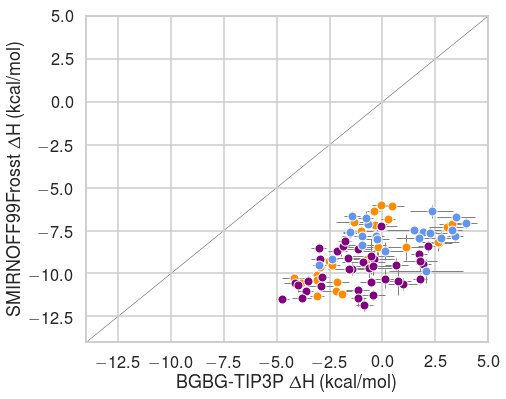

In [380]:
guest_types = all_enthalpy["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    df = all_enthalpy[all_enthalpy["guest_type"] == guest_type]
    

    ax.errorbar(
        df["total_x"],
        df["total_y"],
        xerr=df["total_sem_x"],
        yerr=df["total_sem_y"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )


ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-14, 5)
ax.set_xlim(-14, 5)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("BGBG-TIP3P $\Delta$H (kcal/mol)", labelpad=5)

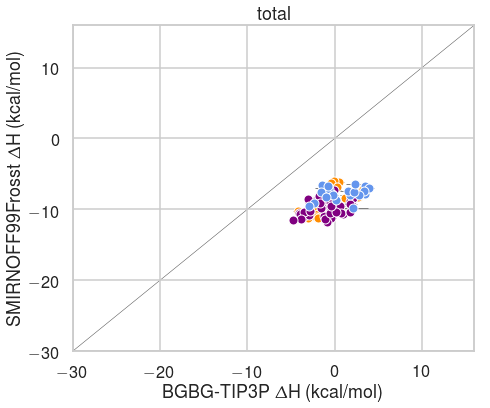

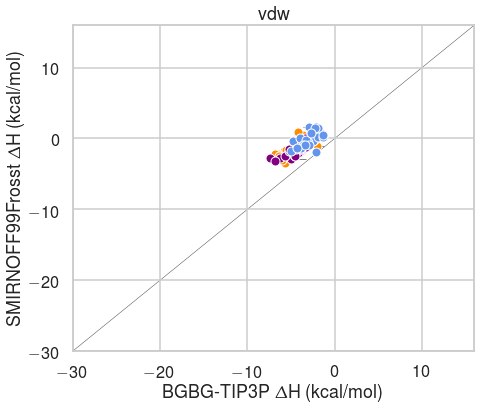

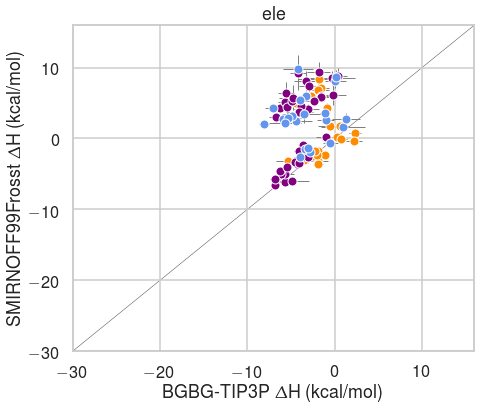

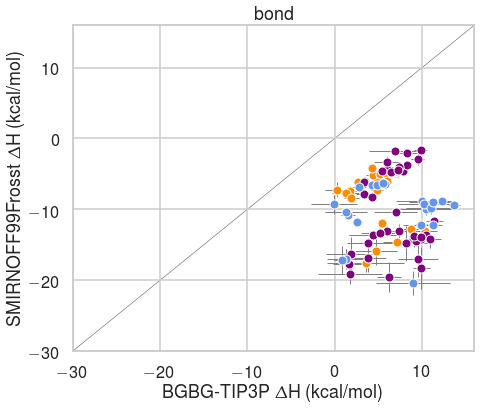

In [381]:
guest_types = all_enthalpy["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


components = ["total", "vdw", "ele", "bond"]
for component in components:

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, guest_type in enumerate(guest_types):
        df = all_enthalpy[all_enthalpy["guest_type"] == guest_type]

        ax.errorbar(
            df[f"{component}_x"],
            df[f"{component}_y"],
            xerr=df[f"{component}_sem_x"],
            yerr=df[f"{component}_sem_y"],
            fmt="o",
            c=colors[guest_type],
            markeredgecolor="w",
            ecolor="0.5",
            elinewidth=1,
        )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-30, 16)
    ax.set_xlim(-30, 16)
    ax.set_title(component)
    ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
    ax.set_xlabel("BGBG-TIP3P $\Delta$H (kcal/mol)", labelpad=5)

In [382]:
smirnoff.head()

,system,total,bond,ele,vdw,total_sem,bond_sem,ele_sem,vdw_sem,guest_type
0,a-bam-p,-6.092075,-7.445669,0.829534,0.524061,0.208348,0.759282,0.426423,0.389364,aliphatic_ammoniums
1,a-bam-s,-7.003142,-7.631088,1.709336,-1.081390,0.204783,0.108583,0.308335,0.135751,aliphatic_ammoniums
2,a-but-p,-7.227384,-7.855652,0.169264,0.459003,0.226446,0.576190,0.389004,0.266776,aliphatic_carboxylates
3,a-but-s,-7.617697,-8.264504,-0.951592,1.598399,0.257632,0.443147,0.624862,0.173465,aliphatic_carboxylates
4,a-cbu-p,-7.820566,-6.874519,-0.628203,-0.317844,0.224033,0.303371,0.367547,0.173567,cyclic_alcohols


In [383]:
combined_smirnoff = pd.DataFrame()
smirnoff["short_system"] = [
    "-".join(row["system"].split("-")[0:2]) for _, row in smirnoff.iterrows()
]


for hg in smirnoff["short_system"].unique():
    df = smirnoff[smirnoff["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_dH = row["total"]
            primary_sem = row["total_sem"]
            primary_bond = row["bond"]
            primary_bond_sem = row["bond_sem"]
            primary_ele = row["ele"]
            primary_ele_sem = row["ele_sem"]
            primary_vdw = row["vdw"]
            primary_vdw_sem = row["vdw_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_dH = row["total"]
            secondary_sem = row["total_sem"]
            secondary_bond = row["bond"]
            secondary_bond_sem = row["bond_sem"]
            secondary_ele = row["ele"]
            secondary_ele_sem = row["ele_sem"]
            secondary_vdw = row["vdw"]
            secondary_vdw_sem = row["vdw_sem"]
    total = thermodynamic_bootstrap(
        primary_dH, primary_sem, secondary_dH, secondary_sem
    )
    bond = thermodynamic_bootstrap(
        primary_bond, primary_bond_sem, secondary_bond, secondary_bond_sem
    )
    ele = thermodynamic_bootstrap(
        primary_ele, primary_ele_sem, secondary_ele, secondary_ele_sem
    )
    vdw = thermodynamic_bootstrap(
        primary_vdw, primary_vdw_sem, secondary_vdw, secondary_vdw_sem
    )
    print(
        f"{hg} P: {primary_dH:+0.4f} ± {primary_sem:+0.2f} S: {secondary_dH:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}"
    )

    combined_smirnoff = combined_smirnoff.append(
        pd.DataFrame(
            {
                "system": hg,
                "smirnoff_all": total["mean"],
                "smirnoff_all_sem": total["sem"],
                "smirnoff_bond": bond["mean"],
                "smirnoff_bond_sem": bond["sem"],
                "smirnoff_ele": ele["mean"],
                "smirnoff_ele_sem": ele["sem"],
                "smirnoff_vdw": vdw["mean"],
                "smirnoff_vdw_sem": vdw["sem"],
                "guest_type": guest_type,
            },
            index=[0],
        ),
        ignore_index=True,
    )


a-bam P: -6.0921 ± +0.21 S: -7.00 ± +0.20 → Boot: -1.27 ± +0.89
a-but P: -7.2274 ± +0.23 S: -7.62 ± +0.26 → Boot: -1.27 ± +0.89
a-cbu P: -7.8206 ± +0.22 S: -7.84 ± +0.21 → Boot: -1.27 ± +0.89
a-chp P: -6.6293 ± +0.27 S: -9.14 ± +0.24 → Boot: -1.27 ± +0.89
a-cpe P: -7.1150 ± +0.25 S: -7.56 ± +0.26 → Boot: -1.27 ± +0.89
a-coc P: -6.7458 ± +0.36 S: -9.48 ± +0.43 → Boot: -1.27 ± +0.89
a-hep P: -11.0372 ± +0.24 S: -10.57 ± +0.22 → Boot: -1.27 ± +0.89
a-ham P: -9.2961 ± +0.20 S: -10.48 ± +0.24 → Boot: -1.27 ± +0.89
a-hp6 P: -10.6970 ± +0.36 S: -10.44 ± +0.27 → Boot: -1.27 ± +0.89
a-hex P: -10.7458 ± +0.25 S: -9.17 ± +0.20 → Boot: -1.27 ± +0.89
a-hx2 P: -10.2292 ± +0.21 S: -8.71 ± +0.23 → Boot: -1.27 ± +0.89
a-hpa P: -10.0637 ± +0.19 S: -11.01 ± +0.23 → Boot: -1.27 ± +0.89
a-mba P: -5.9980 ± +0.22 S: -7.15 ± +0.22 → Boot: -1.27 ± +0.89
a-hx3 P: -8.4271 ± +0.32 S: -8.53 ± +0.28 → Boot: -1.27 ± +0.89
a-mhp P: -10.5418 ± +0.20 S: -10.40 ± +0.25 → Boot: -1.27 ± +0.89
a-mha P: -9.4834 ± +0.22 S: -

In [384]:
combined_bgbg_tip3p = pd.DataFrame()
bgbg_tip3p["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in bgbg_tip3p.iterrows()]


for hg in bgbg_tip3p["short_system"].unique():
    df = bgbg_tip3p[bgbg_tip3p["short_system"] == hg]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_dH = row["total"]
            primary_sem = row["total_sem"]
            primary_bond = row["bond"]
            primary_bond_sem = row["bond_sem"]
            primary_ele = row["ele"]
            primary_ele_sem = row["ele_sem"]
            primary_vdw = row["vdw"]
            primary_vdw_sem = row["vdw_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_dH = row["total"]
            secondary_sem = row["total_sem"]
            secondary_bond = row["bond"]
            secondary_bond_sem = row["bond_sem"]
            secondary_ele = row["ele"]
            secondary_ele_sem = row["ele_sem"]
            secondary_vdw = row["vdw"]
            secondary_vdw_sem = row["vdw_sem"]
    total = thermodynamic_bootstrap(
        primary_dH, primary_sem, secondary_dH, secondary_sem
    )
    bond = thermodynamic_bootstrap(
        primary_bond, primary_bond_sem, secondary_bond, secondary_bond_sem
    )
    ele = thermodynamic_bootstrap(
        primary_ele, primary_ele_sem, secondary_ele, secondary_ele_sem
    )
    vdw = thermodynamic_bootstrap(
        primary_vdw, primary_vdw_sem, secondary_vdw, secondary_vdw_sem
    )
    print(
        f"{hg} P: {primary_dH:+0.4f} ± {primary_sem:+0.2f} S: {secondary_dH:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}"
    )

    combined_bgbg_tip3p = combined_bgbg_tip3p.append(
        pd.DataFrame(
            {
                "system": hg,
                "bgbg_tip3p_all": total["mean"],
                "bgbg_tip3p_all_sem": total["sem"],
                "bgbg_tip3p_bond": bond["mean"],
                "bgbg_tip3p_bond_sem": bond["sem"],
                "bgbg_tip3p_ele": ele["mean"],
                "bgbg_tip3p_ele_sem": ele["sem"],
                "bgbg_tip3p_vdw": vdw["mean"],
                "bgbg_tip3p_vdw_sem": vdw["sem"],
                "guest_type": guest_type,
            },
            index=[0],
        ),
        ignore_index=True,
    )


a-bam P: +0.4380 ± +0.60 S: -1.35 ± +0.86 → Boot: -1.27 ± +0.89
a-but P: -0.0701 ± +0.78 S: -1.54 ± +0.34 → Boot: -1.27 ± +0.89
a-cbu P: -0.2842 ± +0.36 S: -0.98 ± +0.94 → Boot: -1.27 ± +0.89
a-chp P: -1.4365 ± +0.39 S: -2.37 ± +0.28 → Boot: -1.27 ± +0.89
a-cpe P: -0.6788 ± +0.92 S: -1.55 ± +0.31 → Boot: -1.27 ± +0.89
a-coc P: -0.7969 ± +0.34 S: -3.00 ± +0.31 → Boot: -1.27 ± +0.89
a-hep P: -3.6344 ± +0.34 S: -4.13 ± +0.52 → Boot: -1.27 ± +0.89
a-ham P: -2.5099 ± +0.36 S: -2.13 ± +0.54 → Boot: -1.27 ± +0.89
a-hp6 P: -3.9724 ± +0.23 S: -3.54 ± +0.29 → Boot: -1.27 ± +0.89
a-hex P: -2.9244 ± +0.59 S: -2.97 ± +0.40 → Boot: -1.27 ± +0.89
a-hx2 P: -2.8510 ± +0.27 S: -2.13 ± +0.45 → Boot: -1.27 ± +0.89
a-hpa P: -3.0882 ± +0.26 S: -2.18 ± +0.75 → Boot: -1.27 ± +0.89
a-mba P: -0.0572 ± +0.42 S: -0.35 ± +0.48 → Boot: -1.27 ± +0.89
a-hx3 P: -1.8584 ± +0.26 S: -3.02 ± +0.35 → Boot: -1.27 ± +0.89
a-mhp P: -3.8714 ± +0.38 S: -3.10 ± +0.33 → Boot: -1.27 ± +0.89
a-mha P: -2.3648 ± +0.35 S: -1.97 ± +0.2

In [385]:
combined = pd.merge(combined_smirnoff, combined_bgbg_tip3p, on=["system", "guest_type"])

In [386]:
combined.head()

,system,smirnoff_all,smirnoff_all_sem,smirnoff_bond,smirnoff_bond_sem,smirnoff_ele,smirnoff_ele_sem,smirnoff_vdw,smirnoff_vdw_sem,guest_type,bgbg_tip3p_all,bgbg_tip3p_all_sem,bgbg_tip3p_bond,bgbg_tip3p_bond_sem,bgbg_tip3p_ele,bgbg_tip3p_ele_sem,bgbg_tip3p_vdw,bgbg_tip3p_vdw_sem
0,a-bam,-7.132468,0.167272,-8.065745,0.357478,0.670677,0.364487,-1.125506,0.126567,aliphatic_ammoniums,-1.465653,0.787324,0.687426,1.015978,-0.578581,1.238381,-3.759570,0.357681
1,a-but,-7.881752,0.188668,-8.587854,0.367286,-1.124402,0.541415,0.363524,0.227955,aliphatic_carboxylates,-1.646133,0.331284,3.117002,0.688943,-3.683402,0.408239,-2.764123,0.333456
2,a-cbu,-8.257326,0.147931,-7.149566,0.201637,-1.693647,0.244545,-0.522802,0.131585,cyclic_alcohols,-1.286160,0.692699,2.520453,0.810009,-3.429608,0.637763,-2.745719,0.311305
3,a-chp,-9.152407,0.236735,-10.748200,0.498829,-1.944007,0.312675,-0.669533,0.119675,cyclic_alcohols,-2.510975,0.239842,1.463753,0.805539,-2.926571,0.796790,-4.462976,0.202775
4,a-cpe,-7.821350,0.193218,-10.331339,0.208359,-1.330510,0.365677,-0.013882,0.143419,cyclic_alcohols,-1.794591,0.359572,1.231530,2.197168,-3.223408,0.636499,-4.155123,0.242968


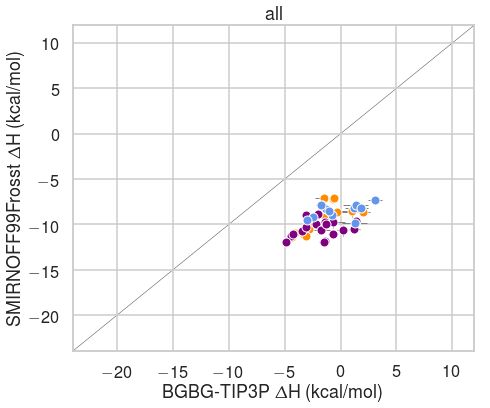

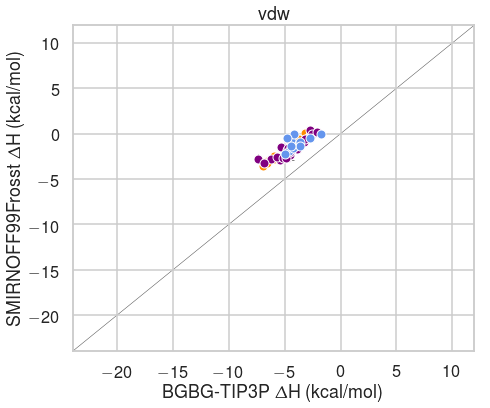

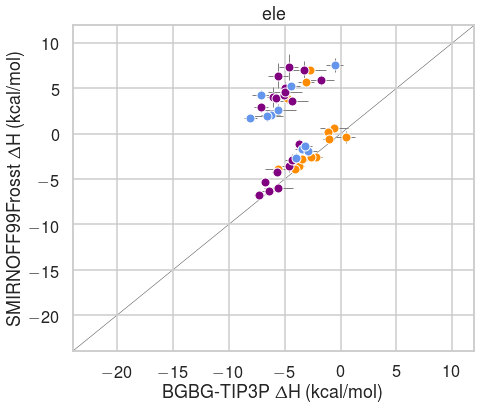

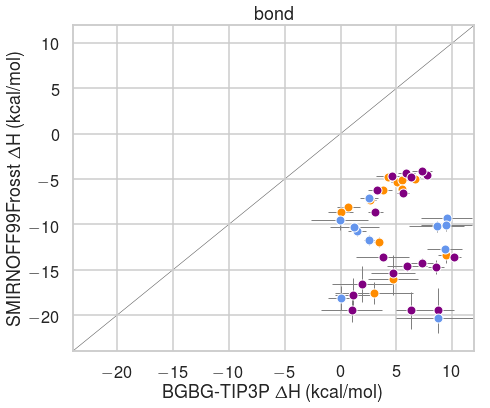

In [389]:
guest_types = all_enthalpy["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


components = ["all", "vdw", "ele", "bond"]
for component in components:

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, guest_type in enumerate(guest_types):
        df = combined[combined["guest_type"] == guest_type]

        ax.errorbar(
            df[f"bgbg_tip3p_{component}"],
            df[f"smirnoff_{component}"],
            xerr=df[f"bgbg_tip3p_{component}_sem"],
            yerr=df[f"smirnoff_{component}_sem"],
            fmt="o",
            c=colors[guest_type],
            markeredgecolor="w",
            ecolor="0.5",
            elinewidth=1,
        )


    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-24, 12)
    ax.set_xlim(-24, 12)
    ax.set_title(component)
    ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
    ax.set_xlabel("BGBG-TIP3P $\Delta$H (kcal/mol)", labelpad=5)